# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/lcances/.miniconda3/envs/ssl/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
import pprint

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [5]:
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.model_loader import load_model
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.mixup import MixUpBatchShuffle
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict
from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import JensenShanon

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

In [6]:
from augmentation_utils.signal_augmentations import Occlusion, SignalAugmentation
from augmentation_utils.spec_augmentations import SpecAugmentation
from augmentation_utils.augmentations import ComposeAugmentation
from mlu.transforms.waveform import StretchPadCrop
from mlu.transforms.base import WaveformTransform, SpectrogramTransform
from mlu.transforms.spectrogram import CutOutSpec

# Arguments

In [7]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../../datasets", type=str)
parser.add_argument("-D", "--dataset", default="speechcommand", type=str)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.001, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)
group_t.add_argument("--num_classes", default=35, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4, 5, 6, 7, 8, 9], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[10], type=int)

group_s = parser.add_argument_group("Student teacher parameters")
group_s.add_argument("--ema_alpha", default=0.999, type=float)
group_s.add_argument("--warmup_length", default=50, type=int)
group_s.add_argument("--lambda_cost_max", default=1.0, type=float)
group_s.add_argument("--teacher_noise", default=0, type=float)
group_s.add_argument("--ccost_softmax", action="store_true", default=False)
group_s.add_argument("--ccost_method", type=str, default="js")

group_mixup = parser.add_argument_group("Mixup parameters")
group_mixup.add_argument("--mixup", action="store_true", default=False)
group_mixup.add_argument("--mixup_alpha", type=float, default=0.4)
group_mixup.add_argument("--mixup_max", action="store_true", default=False)
group_mixup.add_argument("--mixup_label", action="store_true", default=False)

group_a = parser.add_argument_group('augmentations')
group_a.add_argument('--use_augmentation', action='store_true', default=False)
group_a.add_argument('--augmentation_method', type=str, default='pick-one')

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="mean-teacher_mixup", type=str)
group_l.add_argument("--tensorboard_path", default="mean-teacher_mixup", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args=parser.parse_args(["--ccost_softmax", '--ccost_method', 'js'])

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [8]:
pprint.pprint(vars(args))

{'augmentation_method': 'pick-one',
 'batch_size': 64,
 'ccost_method': 'js',
 'ccost_softmax': True,
 'checkpoint_path': 'mean-teacher_mixup',
 'checkpoint_root': '../../model_save/',
 'dataset': 'speechcommand',
 'dataset_root': '../../datasets',
 'ema_alpha': 0.999,
 'from_config': '',
 'lambda_cost_max': 1.0,
 'learning_rate': 0.001,
 'mixup': False,
 'mixup_alpha': 0.4,
 'mixup_label': False,
 'mixup_max': False,
 'model': 'wideresnet28_2',
 'nb_epoch': 200,
 'num_classes': 35,
 'resume': False,
 'seed': 1234,
 'supervised_ratio': 0.1,
 'teacher_noise': 0,
 'tensorboard_path': 'mean-teacher_mixup',
 'tensorboard_root': '../../tensorboard/',
 'tensorboard_sufix': '',
 'train_folds': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'use_augmentation': False,
 'val_folds': [10],
 'warmup_length': 50}


# initialisation

In [9]:
reset_seed(args.seed)

# Prepare the dataset

In [10]:
train_transform, val_transform = load_preprocesser(args.dataset, "mean-teacher")
train_transform

/home/lcances/sync/Documents_sync/Projet/PyTorch/audio/torchaudio/backend/utils.py:52: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


Sequential(
  (0): PadUpTo()
  (1): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (2): AmplitudeToDB()
)

In [11]:
# add transformation for apply augmentation
ratio = 0.5
weak_pool = [
    Occlusion(ratio, sampling_rate=16000, max_size=0.25),
    CutOutSpec(width_scales=(0.1, 0.5), height_scales=(0.1, 0.5), fill_value=-80.0, p=ratio),
    StretchPadCrop(rates=(0.5, 1.5), align="random", p=ratio),
]

In [12]:
# Create the augmentation composer
composer = ComposeAugmentation(
    pre_process_rule=lambda x: isinstance(x, (SignalAugmentation, WaveformTransform)),
    post_process_rule=lambda x: isinstance(x, (SpecAugmentation, SpectrogramTransform)),
)
composer.set_augmentation_pool(weak_pool)
composer.set_process(train_transform)

In [13]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "mean-teacher",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=composer,
    val_transform=val_transform,
    
    num_workers=0,
    pin_memory=True,

    verbose = 1
)

../../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified
../../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified
../../datasets/SpeechCommands/speech_commands_v0.02


100%|██████████| 35/35 [00:00<00:00, 788.68it/s]


In [15]:
input_shape = tuple(train_loader._iterables[0].dataset[0][0].shape)
input_shape

(64, 32)

# Prep model

In [16]:
torch.cuda.empty_cache()

model_func = load_model(args.dataset, args.model)

student = model_func(input_shape=input_shape, num_classes = args.num_classes)
teacher = model_func(input_shape=input_shape, num_classes = args.num_classes)

student = student.cuda()
teacher = teacher.cuda()

# We do not need gradient for the teacher model
for p in teacher.parameters():
    p.detach()

In [17]:
from torchsummary import summary

s = summary(student, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             288
       BatchNorm2d-2           [-1, 32, 64, 32]              64
              ReLU-3           [-1, 32, 64, 32]               0
         MaxPool2d-4           [-1, 32, 32, 16]               0
            Conv2d-5           [-1, 32, 32, 16]           9,216
       BatchNorm2d-6           [-1, 32, 32, 16]              64
              ReLU-7           [-1, 32, 32, 16]               0
            Conv2d-8           [-1, 32, 32, 16]           9,216
       BatchNorm2d-9           [-1, 32, 32, 16]              64
             ReLU-10           [-1, 32, 32, 16]               0
       BasicBlock-11           [-1, 32, 32, 16]               0
           Conv2d-12           [-1, 32, 32, 16]           9,216
      BatchNorm2d-13           [-1, 32, 32, 16]              64
             ReLU-14           [-1, 32,

# training parameters

In [18]:
tensorboard_root=f"{args.model}/{args.supervised_ratio}/{get_datetime()}_{model_func.__name__}"
checkpoint_root = f"{args.model}/{args.supervised_ratio}/{model_func.__name__}"

# mea teacher parameters
sufix_title = f'_{args.ema_alpha}-emaa'
sufix_title += f'_{args.warmup_length}-wl'
sufix_title += f'_{args.lambda_cost_max}-lccm'

# mixup parameters
if args.mixup:
    sufix_title += "_mixup"
    if args.mixup_max: sufix_title += "-max"
    if args.mixup_label: sufix_title += "-label"
    sufix_title += f"-{args.mixup_alpha}-a"
    
# ccost function and method
if args.ccost_method: sufix_title += f"_cc-{args.ccost_method.upper()}"
if args.ccost_softmax: sufix_title += "-SOFTMAX"
    
# normale training parameters
sufix_title += f'_{args.learning_rate}-lr'
sufix_title += f'_{args.supervised_ratio}-sr'
sufix_title += f'_{args.nb_epoch}-e'
sufix_title += f'_{args.batch_size}-bs'
sufix_title += f'_{args.seed}-seed'

tensorboard_title = tensorboard_root + sufix_title
checkpoint_title = checkpoint_root + sufix_title

In [19]:
print(os.path.join(tensorboard_path, tensorboard_title))

../../tensorboard/speechcommand/mean-teacher_mixup/wideresnet28_2/0.1/2021-02-22_19:30:13_wideresnet28_2_0.999-emaa_50-wl_1.0-lccm_cc-JS-SOFTMAX_0.001-lr_0.1-sr_200-e_64-bs_1234-seed


## optimizer & callbacks

In [20]:
optimizer = load_optimizer(args.dataset, "mean-teacher", student=student, learning_rate=args.learning_rate)
callbacks = load_callbacks(args.dataset, "mean-teacher", optimizer=optimizer, nb_epoch=args.nb_epoch)

In [21]:
# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean") # Supervised loss

if args.ccost_method == "mse":
    consistency_cost = nn.MSELoss(reduction="mean") # Unsupervised loss
elif args.ccost_method == "js":
    consistency_cost = JensenShanon
        
lambda_cost = Warmup(args.lambda_cost_max, args.warmup_length, sigmoid_rampup)
callbacks += [lambda_cost]

# Checkpoint
checkpoint = CheckPoint(student, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

checkpoint initialise at:  /home/lcances/sync/Documents_sync/Projet/semi-supervised/model_save/speechcommand/mean-teacher_mixup/wideresnet28_2/0.1/wideresnet28_2_0.999-emaa_50-wl_1.0-lccm_cc-JS-SOFTMAX_0.001-lr_0.1-sr_200-e_64-bs_1234-seed.torch
name:  wideresnet28_2_0.999-emaa_50-wl_1.0-lccm_cc-JS-SOFTMAX_0.001-lr_0.1-sr_200-e_64-bs_1234-seed.torch
mode:  max


In [22]:
consistency_cost

<function SSL.losses.JensenShanon(logits_1, logits_2)>

## Metrics definition

In [23]:
def metrics_calculator():
    def c(logits, y):
        with torch.no_grad():
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)
            
            pred = torch.softmax(logits, dim=1)
            arg = torch.argmax(logits, dim=1)
            
            acc = c.fn.acc(arg, y)
            acc = acc.mean
            f1 = c.fn.f1(pred, y_one_hot).mean
            
            return acc, f1,
            
    c.fn = DotDict(
        acc = CategoricalAccuracy(),
        f1 = FScore(),
    )
    
    return c

In [24]:
calc_student_s_metrics = metrics_calculator()
calc_student_u_metrics = metrics_calculator()
calc_teacher_s_metrics = metrics_calculator()
calc_teacher_u_metrics = metrics_calculator()

avg_Sce = ContinueAverage()
avg_Tce = ContinueAverage()
avg_ccost = ContinueAverage()

softmax_fn = lambda x: x
if args.ccost_softmax:
    softmax_fn = nn.Softmax(dim=1)

def reset_metrics():
    for d in [calc_student_s_metrics.fn, calc_student_u_metrics.fn, calc_teacher_s_metrics.fn, calc_teacher_u_metrics.fn]:
        for fn in d.values():
            fn.reset()

maximum_tracker = track_maximum()

## Can resume previous training

In [25]:
if args.resume:
    checkpoint.load_last()

In [26]:
args.resume

False

## training function

In [27]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"

header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} | {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} - {:<8.6}"
value_form  = "{:<8.8} {:<6d} - {:<6d} - {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} | {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} - {:<8.4f}"
header = header_form.format(".               ", "Epoch",  "%", "Student:", "ce", "ccost", "acc_s", "f1_s", "acc_u", "f1_u", "Teacher:", "ce", "acc_s", "f1_s", "acc_u", "f1_u" , "Time")

train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Student:   ce       ccost    acc_s    f1_s     acc_u    f1_u     | Teacher:   ce       acc_s    f1_s     acc_u    f1_u     - Time    


In [28]:
def update_teacher_model(student_model, teacher_model, alpha, epoch):
    
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (epoch + 1), alpha)
    
    for param, ema_param in zip(student_model.parameters(), teacher_model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data,  alpha = 1-alpha)


noise_fn = lambda x: x
if args.teacher_noise != 0:
    n_db = args.teacher_noise
    noise_fn = transforms.Lambda(lambda x: x + (torch.rand(x.shape).cuda() * n_db + n_db))

In [29]:
mixup_fn = MixUpBatchShuffle(alpha=args.mixup_alpha, apply_max=args.mixup_max, mix_labels=args.mixup_label)

In [30]:
def train(epoch):
    start_time = time.time()
    print("")
    
    nb_batch = len(train_loader)

    reset_metrics()
    student.train()

    for i, (S, U) in enumerate(train_loader):        
        x_s, y_s = S
        x_u, y_u = U

        # Apply mixup if needed, otherwise no mixup.
        n_x_s, n_y_s, n_x_u, n_y_u = x_s, y_s, x_u, y_u
        if args.mixup:
            n_x_s, n_y_s = mixup_fn(x_s, y_s)
            n_x_u, n_y_u = mixup_fn(x_u, y_u)
        
        n_x_s, n_x_u = n_x_s.cuda(), n_x_u.cuda()
        x_s, x_u = x_s.cuda(), x_u.cuda()
        y_s, y_u = y_s.cuda(), y_u.cuda()
        
        # Predictions
        student_s_logits = student(x_s)        
        student_u_logits = student(x_u)
        teacher_s_logits = teacher(n_x_s)
        teacher_u_logits = teacher(n_x_u)
        
        # Calculate supervised loss (only student on S)
        loss = loss_ce(student_s_logits, y_s)
        
        # Calculate consistency cost (mse(student(x), teacher(x))) x is S + U
        student_logits = torch.cat((student_s_logits, student_u_logits), dim=0)
        teacher_logits = torch.cat((teacher_s_logits, teacher_u_logits), dim=0)
        ccost = consistency_cost(softmax_fn(student_logits), softmax_fn(teacher_logits))

        total_loss = loss + lambda_cost() * ccost
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            # Teacher prediction (for metrics purpose)
            _teacher_loss = loss_ce(teacher_s_logits, y_s)
            
            # Update teacher
            update_teacher_model(student, teacher, args.ema_alpha, epoch*nb_batch + i)
            
            # Compute the metrics for the student
            student_s_metrics = calc_student_s_metrics(student_s_logits, y_s)
            student_u_metrics = calc_student_u_metrics(student_u_logits, y_u)
            student_s_acc, student_s_f1, student_u_acc, student_u_f1 = *student_s_metrics, *student_u_metrics
            
            # Compute the metrics for the teacher
            teacher_s_metrics = calc_teacher_s_metrics(teacher_s_logits, y_s)
            teacher_u_metrics = calc_teacher_u_metrics(teacher_u_logits, y_u)
            teacher_s_acc, teacher_s_f1, teacher_u_acc, teacher_u_f1 = *teacher_s_metrics, *teacher_u_metrics
            
            # Running average of the two losses
            student_running_loss = avg_Sce(loss.item()).mean
            teacher_running_loss = avg_Tce(_teacher_loss.item()).mean
            running_ccost = avg_ccost(ccost.item()).mean

            # logs
            print(train_form.format(
                "Training: ", epoch + 1, int(100 * (i + 1) / nb_batch),
                "", student_running_loss, running_ccost, *student_s_metrics, *student_u_metrics,
                "", teacher_running_loss, *teacher_s_metrics, *teacher_u_metrics,
                time.time() - start_time),
                end="\r")

    tensorboard.add_scalar("train/student_acc_s", student_s_acc, epoch)
    tensorboard.add_scalar("train/student_acc_u", student_u_acc, epoch)
    tensorboard.add_scalar("train/student_f1_s", student_s_f1, epoch)
    tensorboard.add_scalar("train/student_f1_u", student_u_f1, epoch)
    
    tensorboard.add_scalar("train/teacher_acc_s", teacher_s_acc, epoch)
    tensorboard.add_scalar("train/teacher_acc_u", teacher_u_acc, epoch)
    tensorboard.add_scalar("train/teacher_f1_s", teacher_s_f1, epoch)
    tensorboard.add_scalar("train/teacher_f1_u", teacher_u_f1, epoch)
    
    tensorboard.add_scalar("train/student_loss", student_running_loss, epoch)
    tensorboard.add_scalar("train/teacher_loss", teacher_running_loss, epoch)
    tensorboard.add_scalar("train/consistency_cost", running_ccost, epoch)

In [31]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    student.eval()
    
    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            # Predictions
            student_logits = student(X)        
            teacher_logits = teacher(X)

            # Calculate supervised loss (only student on S)
            loss = loss_ce(student_logits, y)
            _teacher_loss = loss_ce(teacher_logits, y) # for metrics only
            ccost = consistency_cost(softmax_fn(student_logits), softmax_fn(teacher_logits))
            
            # Compute the metrics
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)
            
            # ---- student ----
            student_metrics = calc_student_s_metrics(student_logits, y)
            student_acc, student_f1 = student_metrics
            
            # ---- teacher ----
            teacher_metrics = calc_teacher_s_metrics(teacher_logits, y)
            teacher_acc, teacher_f1 = teacher_metrics

            # Running average of the two losses
            student_running_loss = avg_Sce(loss.item()).mean
            teacher_running_loss = avg_Tce(_teacher_loss.item()).mean
            running_ccost = avg_ccost(ccost.item()).mean

            # logs
            print(val_form.format(
                "Validation: ", epoch + 1, int(100 * (i + 1) / len(val_loader)),
                "", student_running_loss, running_ccost, *student_metrics, 0.0, 0.0,
                "", teacher_running_loss, *teacher_metrics, 0.0, 0.0,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/student_acc", student_acc, epoch)
    tensorboard.add_scalar("val/student_f1", student_f1, epoch)
    tensorboard.add_scalar("val/teacher_acc", teacher_acc, epoch)
    tensorboard.add_scalar("val/teacher_f1", teacher_f1, epoch)
    tensorboard.add_scalar("val/student_loss", student_running_loss, epoch)
    tensorboard.add_scalar("val/teacher_loss", teacher_running_loss, epoch)
    tensorboard.add_scalar("val/consistency_cost", running_ccost, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    tensorboard.add_scalar("hyperparameters/lambda_cost_max", lambda_cost(), epoch)
    
    tensorboard.add_scalar("max/student_acc", maximum_tracker("student_acc", student_acc), epoch )
    tensorboard.add_scalar("max/teacher_acc", maximum_tracker("teacher_acc", teacher_acc), epoch )
    tensorboard.add_scalar("max/student_f1", maximum_tracker("student_f1", student_f1), epoch )
    tensorboard.add_scalar("max/teacher_f1", maximum_tracker("teacher_f1", teacher_f1), epoch )

    checkpoint.step(teacher_acc)
    for c in callbacks:
        c.step()


# Training

In [32]:
tensorboard = mSummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)


start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

print(header)
for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()

.        Epoch  - %      - Student:   ce       ccost    acc_s    f1_s     acc_u    f1_u     | Teacher:   ce       acc_s    f1_s     acc_u    f1_u     - Time    

Training 1      - 100    -            2.8633   0.0002   0.2084   0.0610   0.2477   0.1013   |            2.9542   0.2146   0.0038   0.2473   0.0197   - 338.2091
Validati 1      - 100    -            2.7941   0.0003   0.3869   0.2735   0.0000   0.0000   |            2.8809   0.4360   0.1195   0.0000   0.0000   - 20.5813 
Training 2      - 100    -            2.3098   0.0003   0.5313   0.4001   0.5809   0.5014   |            2.3755   0.5568   0.2844   0.6068   0.4021   - 247.0746
Validati 2      - 100    -            2.2825   0.0004   0.5355   0.4956   0.0000   0.0000   |            2.3325   0.6180   0.5468   0.0000   0.0000   - 6.2211  
Training 3      - 100    -            1.9946   0.0004   0.6656   0.6086   0.6833   0.6647   |            1.9916   0.7200   0.6340   0.7297   0.6931   - 241.5070
Validati 3      - 100    -       

KeyboardInterrupt: 

## Save the hyper parameters and the metrics

In [59]:
hparams = {}
for key, value in args.__dict__.items():
    hparams[key] = str(value)

final_metrics = {
    "max_acc_student": maximum_tracker.max["student_acc"],
    "max_f1_student": maximum_tracker.max["student_f1"],
    "max_acc_teacher": maximum_tracker.max["teacher_acc"],
    "max_f1_teacher": maximum_tracker.max["teacher_f1"],
}

tensorboard.add_hparams(hparams, final_metrics)

tensorboard.flush()
tensorboard.close()

KeyError: 'student_acc'

## display

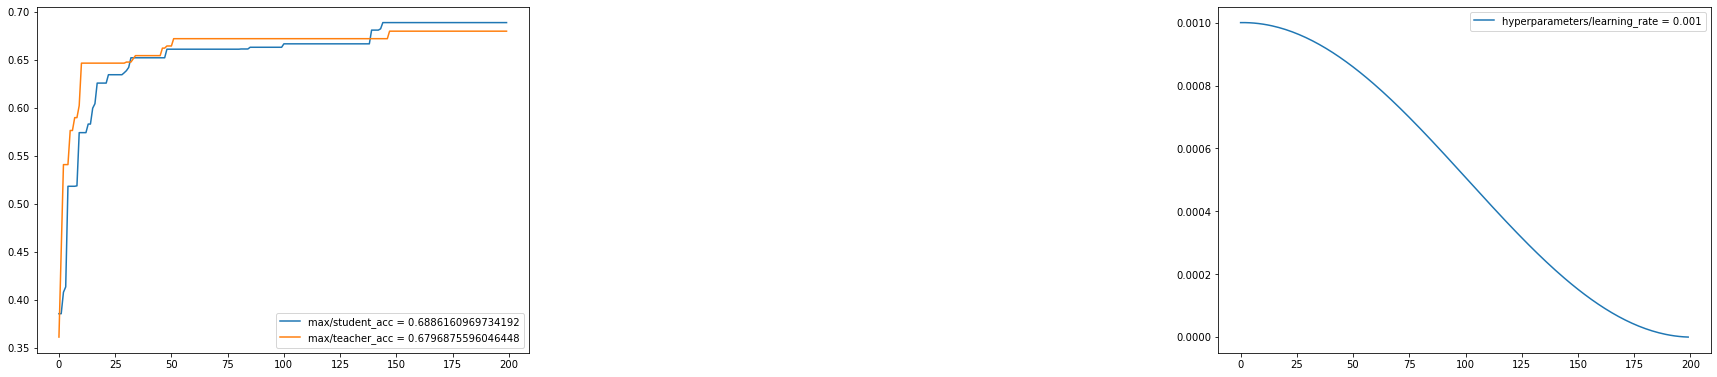

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x = list(range(checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("max/student_acc")
pp("max/teacher_acc")
plt.legend()

plt.subplot(2, 3, 3)
pp("hyperparameters/learning_rate")
plt.legend()

plt.show()

In [30]:
plt.hist(mixup_fn.lambda_history, bins=20)
plt.show()

ModuleAttributeError: 'MixUpBatchShuffle' object has no attribute 'lambda_history'

In [ ]:
320000*2/1024

In [ ]:
64*500*4/1024

In [ ]:
625/125

24.0